<h1>Proyecto Limpieza da Datos - Fichero BMW</h1>

El objetivo es predecir el precio del vehículo, para ello en este primer entregable se necesitará realizar todo el data cleaning y data preprocessing de los datos (ojo que si bien el objetivo es predecir el precio no será necesario hacer la predicción)

Forma de entrega:

Se debe entregar lo siguiente - 

- Un documento (Word/pdf) de máximo 3 páginas (letra 12) donde se explique:

    - Qué columnas eliminaron (en caso se haya eliminado)
    - Qué se hizo con los nulos y cómo se limpiaron las columnas
    - Comentarios del análisis univariable, están todas ok? Hay alguna con outliers? Hay alguna por agrupar?
    - Análisis de Correlación inicial, hay alguna variable correlacionada?
    - Análisis variable vs target, hay algún insight interesante?
    - Transformación de categóricas a numéricas, que variables van a transformar? que técnica se va usar?
    - Normalizar variables numéricas
    - Análisis de correlación final, hay alguna variable correlacionada?
    - **Y finalmente deben poner la lista de columnas completa que tendría su dataset limpio y preprocesado (además del tipo de dato de cada columna) y un pantallazo de las 5 primeras líneas (si esto no entra en 3 páginas lo pueden agregar como anexo)**

    Se puede agregar pantallazos de algunos outputs, importante controlar las 3 páginas mencionadas, lo cual deben ser pantallazos importantes

- Programa: en este programa debe estar todo el proceso de limpieza y preprocesamiento del dataset, tanto código, comentarios como también el output de cada paso

Criterios de evaluación:
Documento con todo lo mencionado arriba (60%)
Programa (40%)

**Se puede hacer tanto en grupo como individual el trabajo**

Plazo de entrega: 26 de noviembre (no habrá prorroga)

In [2]:
#importamos librería
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import plotly.express as px
from scipy import stats

import math

In [3]:
def listarNulos(dataset):
    df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["percentaje"] = percent.round(2)
    return df_stat


In [4]:
def qui_quadrado(df, variavel, lista):

  # Calcular Qui2 e p-valor para cada variável e colocar resultado num df
  d = {'Qui2': [], 'p-Valor': []}

  for l in lista:
      
      # Cria tabela que relaciona variável com lista
      tab = pd.crosstab(df[variavel], df[l])

      # Calcula o qui2 entre as duas variáveis
      chi_scores = chi2_contingency(tab)

      # Recupera o valor e p-value do teste
      scores = pd.Series(chi_scores[0])
      pvalues = pd.Series(chi_scores[1])

      # Adiciona resultado ao dicionário
      d['Qui2'].append(scores[0])
      d['p-Valor'].append(pvalues[0])

  # Transformar dicionário em dataframe
  chi_squared = pd.DataFrame(d)

  # Formato de visualização dos números
  pd.options.display.float_format = "{:,.2f}".format

  # Renomear linhas do df
  for n, l in zip(np.arange(0, len(lista), 1), lista[0:len(lista)]):
    chi_squared = chi_squared.rename(index = {n: l})

  # Mostrar em ordem crescente para o p-valor
  chi_squared = chi_squared.sort_values(by = 'p-Valor', ascending = True)

  # Visualizar df
  return chi_squared

In [5]:
df_bmw = pd.read_csv("Datos/bmw_pricing_v3.csv")


In [6]:
print(df_bmw.info())
df_variables_con_nulos = listarNulos(df_bmw)
print(df_variables_con_nulos)
df_bmw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [7]:
#VALORES NULOS

#1. Eliminación de las filas con contenido nulo en las variables "precio, tipo_gasolina, volante_regulable, modelo, camara_trasera, elevalunas_electrico,km, potencia, fecha_venta", por su baja indicencia (<0.2 %)
#filas_eliminar = ["precio", "tipo_gasolina", "volante_regulable", modelo, camara_trasera, elevalunas_electrico,km, potencia, fecha_venta"

#percentaje de recorte - nulos: en el caso, 1%
recorte_indice = 1

#Eliminar nulos
filas_eliminar = df_variables_con_nulos[df_variables_con_nulos["percentaje"]<recorte_indice].index
df_bmw.dropna(subset=filas_eliminar, inplace=True)

#Verificación
df_variables_con_nulos = listarNulos(df_bmw)
df_variables_con_nulos
#print(df_bmw[filas_eliminar].isna().any())


,Nulos,percentaje
asientos_traseros_plegables,3373,70.02
fecha_registro,2409,50.01
tipo_coche,1449,30.08
marca,965,20.03
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01
color,442,9.18


In [8]:
#2. Eliminar la variable "asientos_traseros_plegables", por contener 70% de su contenido como nulo:
df_bmw.drop(columns="asientos_traseros_plegables", inplace=True)



In [9]:
#2. Verificación
df_variables_con_nulos = listarNulos(df_bmw)
df_variables_con_nulos

,Nulos,percentaje
fecha_registro,2409,50.01
tipo_coche,1449,30.08
marca,965,20.03
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01
color,442,9.18


In [10]:
#3. MARCA
#Valores
df_bmw.marca.unique()


array([nan, 'BMW'], dtype=object)

In [11]:
#3. En princípio, podríamos remplazar los valores nulos de "marca" por "BMW", que es de que se trata el Dataset. 
# Pero, para garantizar la integridad de los datos, podemos remplazar los valores nulos de "marca" pelo valor da "marca" de coches de mismo modelo. Luego:

# universo de modelos de marca != Null 
lista_modelos = df_bmw["modelo"][~df_bmw["marca"].isnull()].sort_values(ascending=True).unique() 

# universo de modelos de marca == Null 
lista_modelos_null = df_bmw["modelo"][df_bmw["marca"].isnull()].sort_values(ascending=True).unique() 

#Hay "modelos" con "marca=null" que no estan contenidos en "modelos" de "marca=bmw". 

print(lista_modelos)
print("\n", lista_modelos_null)



[' Active Tourer' '114' '116' '118' '120' '123' '125' '135'
 '214 Gran Tourer' '216' '216 Active Tourer' '216 Gran Tourer' '218'
 '218 Active Tourer' '218 Gran Tourer' '220' '225' '316' '318'
 '318 Gran Turismo' '320' '320 Gran Turismo' '325' '325 Gran Turismo'
 '328' '330' '330 Gran Turismo' '335' '335 Gran Turismo' '418 Gran Coupé'
 '420' '420 Gran Coupé' '425' '430' '430 Gran Coupé' '435'
 '435 Gran Coupé' '518' '520' '520 Gran Turismo' '523' '525' '528' '530'
 '530 Gran Turismo' '535' '535 Gran Turismo' '635' '640' '640 Gran Coupé'
 '650' '730' '735' '740' '750' 'ActiveHybrid 5' 'M135' 'M3' 'M4' 'M5'
 'M550' 'X1' 'X3' 'X4' 'X5' 'X5 M' 'X5 M50' 'X6' 'X6 M' 'Z4' 'i3' 'i8']

 ['114' '116' '118' '120' '125' '135' '218' '218 Active Tourer'
 '218 Gran Tourer' '220' '220 Active Tourer' '225 Active Tourer' '316'
 '318' '318 Gran Turismo' '320' '320 Gran Turismo' '325' '328' '330'
 '418 Gran Coupé' '420' '420 Gran Coupé' '425' '435' '435 Gran Coupé'
 '518' '520' '520 Gran Turismo' '525' '52

In [12]:
#Reemplazo de los valores nulos en "marca":
x=0
for i in range(df_bmw.shape[0]):
    if((df_bmw.iloc[i,0]!="BMW") & (df_bmw.iloc[i,1] in lista_modelos)):
        df_bmw.iloc[i,0]="BMW"



In [13]:
#3. Verificación
listarNulos(df_bmw)

,Nulos,percentaje
fecha_registro,2409,50.01
tipo_coche,1449,30.08
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01
color,442,9.18
marca,6,0.12


In [14]:
#Considerando que hay solo 6 filas con "marca=nulo" después del reemplazo, utilizaremos de la premisa inicial de que todo el dataset se trata de coches con "marca=bmw" al revés de borrarlas:
df_bmw["marca"]="BMW"


In [15]:
#3. Verificación
listarNulos(df_bmw)

,Nulos,percentaje
fecha_registro,2409,50.01
tipo_coche,1449,30.08
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01
color,442,9.18


<Axes: xlabel='tipo_coche', ylabel='precio'>

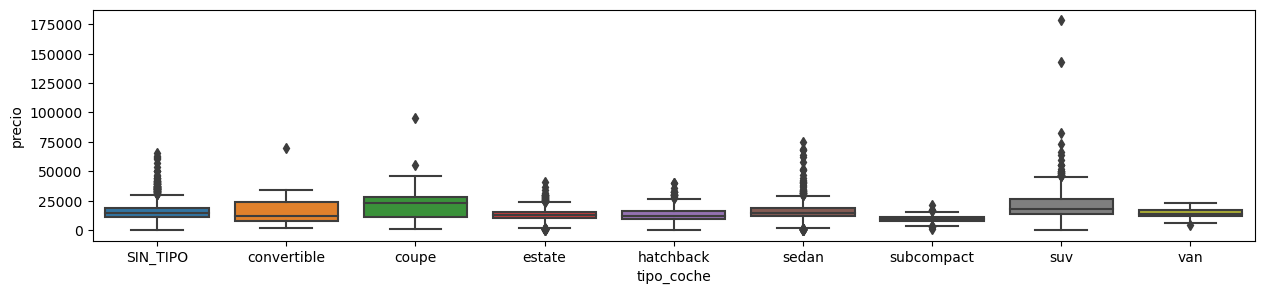

In [16]:
#4. TIPO_COCHE
# El perncentaje de nulos (30% , +- 1500 filas) no parece demasiado alto que justifique eliminar la variable, tampoco demasiado bajo para eliminar las filas. 
# Podríamos verificar la posibilidad de recuperar los valores nulos por medio de otras variables del dataset, como "marca" y "modelo".
# Antes, sin embargo, cabe verificar si la variable es relevante para la composición de los precios (target):

#Copia para investigación
df_bmw_sintipo = df_bmw.copy()

#Atribución inicial del valor "SIN_TIPO" en lugar de nulos, solo para evaluar su impacto en el conjunto:
df_bmw_sintipo["tipo_coche"].fillna("SIN_TIPO",inplace=True)

#Análisis TIPO_COCHE vs PRECIO:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
#sns.violinplot(data=df_bmw[df_bmw["tipo_coche"].isin(["coupe","suv","convertible"])], x="tipo_coche", y="precio")
#sns.boxplot(data=df_bmw_sintipo[df_bmw_sintipo["precio"]<40000], x="tipo_coche", y="precio")
sns.boxplot(data=df_bmw_sintipo, x="tipo_coche", y="precio")

In [17]:
df_bmw["tipo_coche"].value_counts()

tipo_coche
estate         1097
sedan           821
suv             754
hatchback       488
subcompact       77
coupe            73
convertible      30
van              28
Name: count, dtype: int64

<Axes: xlabel='tipo_coche', ylabel='precio'>

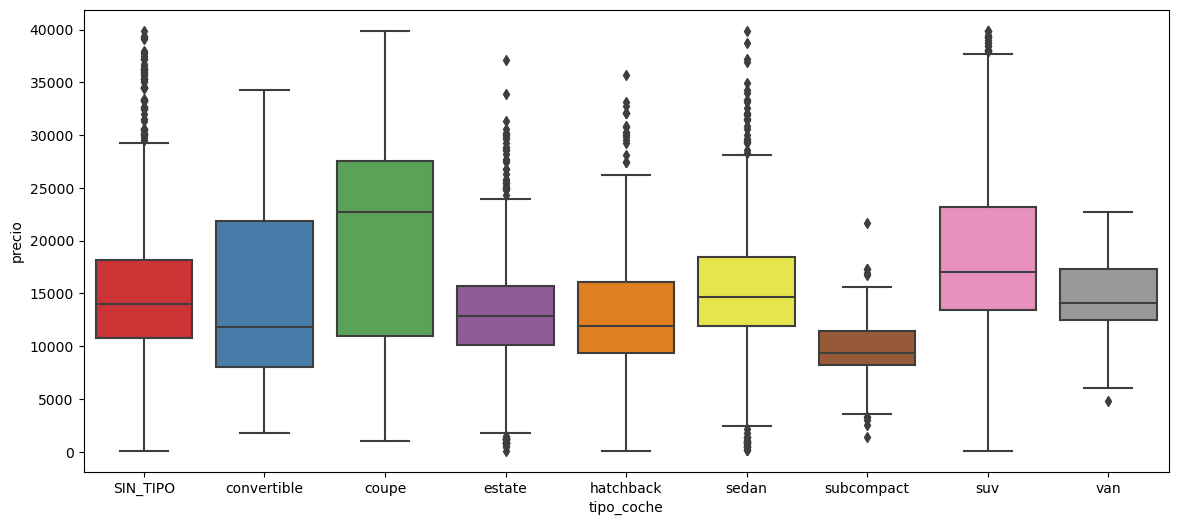

In [18]:
#Eliminación de outliers para facilitar el análisis visual:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.boxplot(data=df_bmw_sintipo[df_bmw_sintipo["precio"]<40000], x="tipo_coche", y="precio", palette="Set1")

In [19]:
#Parece que, de hecho, el tipo de coche influye en el precio. Luego, parece ser relevante el intento de recuperación de los valores nulos. 
#Retomando el dataset original:

df_tipo_coche_modelo_sin_nulos = df_bmw[~df_bmw["tipo_coche"].isnull()].groupby(["modelo","tipo_coche"],as_index=False,dropna=False)["modelo"].value_counts().sort_values(by="count", ascending=False)
print(df_tipo_coche_modelo_sin_nulos)


#sub = df_bmw_sintipo[df_bmw_sintipo["tipo_coche"]=="SIN_TIPO"].groupby(["modelo","tipo_coche"],as_index=False,dropna=False)["modelo"].value_counts().sort_values(by="count", ascending=False)
df_tipo_coche_modelo_nulos = df_bmw[df_bmw["tipo_coche"].isnull()].groupby(["modelo","tipo_coche"],as_index=False,dropna=False)["modelo"].value_counts().sort_values(by="count", ascending=False)
print(df_tipo_coche_modelo_nulos)

#sub_ = df_bmw[~df_bmw["tipo_coche"].isnull()].groupby(["modelo","tipo_coche"],as_index=False,dropna=False)["modelo"].value_counts().sort_values(by="count", ascending=False)


               modelo   tipo_coche  count
132                X3          suv    311
48                320       estate    304
40                318       estate    270
88                520       estate    232
90                520        sedan    197
..                ...          ...    ...
68                335       estate      1
62                330  convertible      1
61                328        sedan      1
58   325 Gran Turismo       estate      1
141                i8        coupe      1

[142 rows x 3 columns]
               modelo  tipo_coche  count
13                320         NaN    231
29                520         NaN    195
11                318         NaN    176
49                 X3         NaN    125
1                 116         NaN    106
48                 X1         NaN     80
10                316         NaN     69
51                 X5         NaN     63
32                525         NaN     52
2                 118         NaN     45
34                530

In [20]:
#Se verifica que hay "modelo" con unico valor "tipo_coche" y "modelo" con multiples valores. 
#Así, tiene más sentido remplazar "tipo_coche=nulo" por la moda del contenido no nulo de la variable, en caso de coches de mismo modelo. 
df_bmw["tipo_coche"].fillna(df_bmw["tipo_coche"].mode()[0],inplace=True)

<Axes: xlabel='tipo_coche', ylabel='precio'>

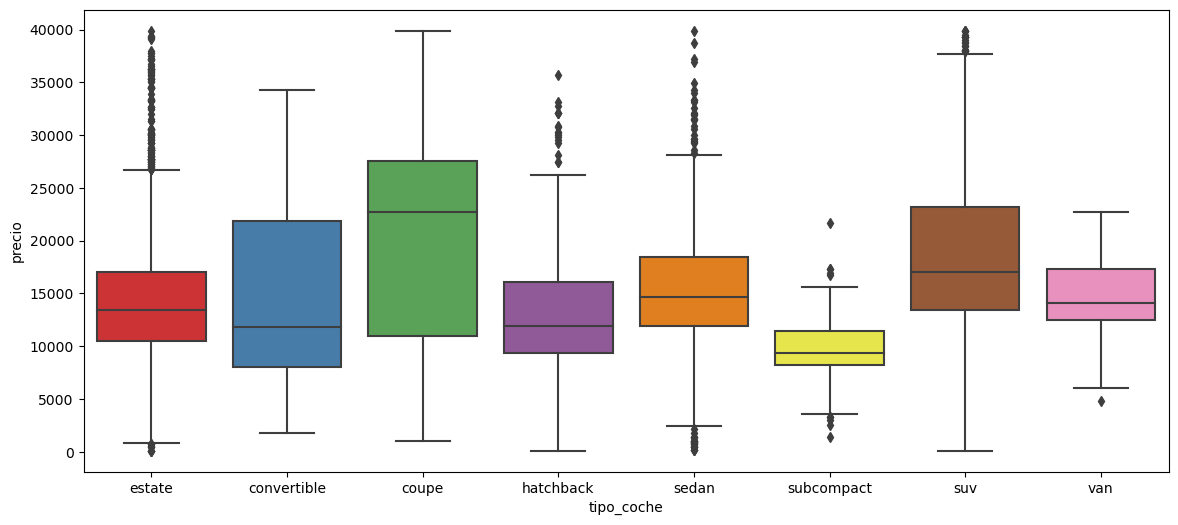

In [21]:
#verificación 
plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.boxplot(data=df_bmw[df_bmw["precio"]<40000], x="tipo_coche", y="precio", palette="Set1")

In [22]:
listarNulos(df_bmw)

,Nulos,percentaje
fecha_registro,2409,50.01
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01
color,442,9.18


In [23]:
####### FIN HASTA EL MOMENTO ########

/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


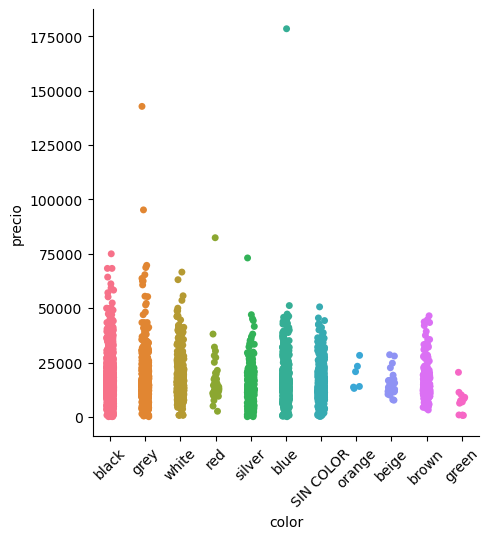

In [32]:
#5. COLOR:
plot = sns.catplot(data=df_bmw, x="color", y="precio", hue="color", kind="strip")
plot.set_xticklabels(rotation=45)


In [30]:
#La variable parece no impactar en el precio, por lo cual se remplazará sus nulos por "SIN COLOR"
df_bmw["color"].fillna("SIN COLOR", inplace=True)
listarNulos(df_bmw)

,Nulos,percentaje
fecha_registro,2409,50.01
bluetooth,725,15.05
alerta_lim_velocidad,725,15.05
aire_acondicionado,482,10.01


/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


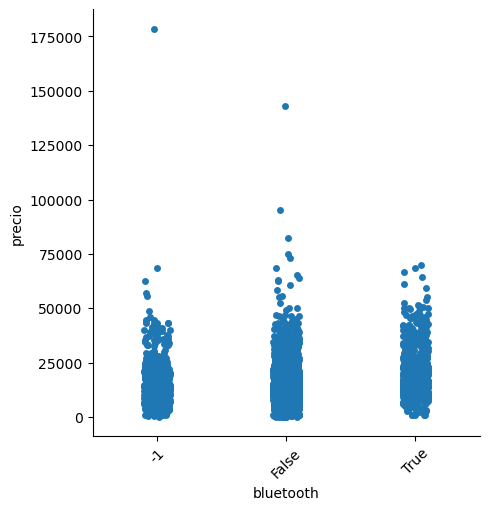

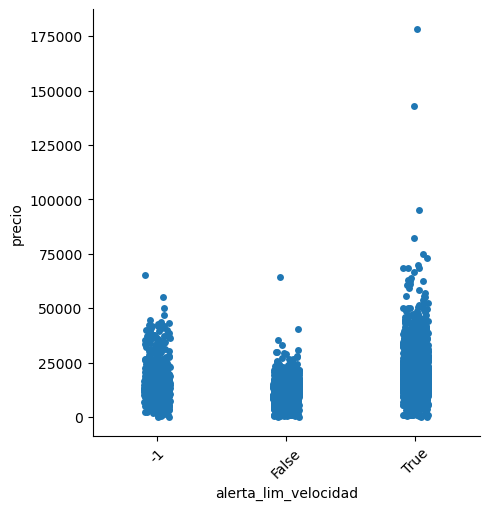

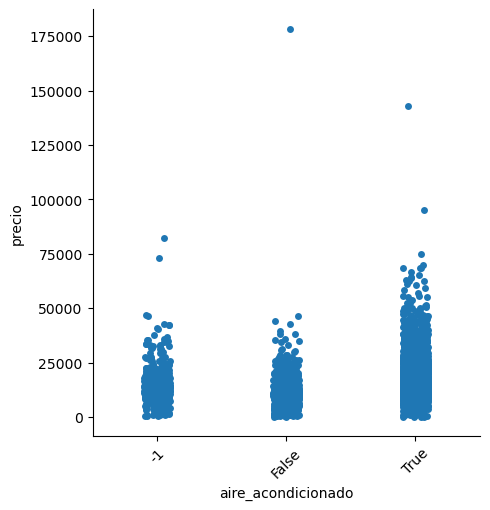

In [58]:
for i in (["bluetooth", "alerta_lim_velocidad", "aire_acondicionado"]):
    plot = sns.catplot(data=df_bmw, x=i, y="precio", kind="strip")
    plot.set_xticklabels(rotation=45)

In [43]:
#Las variables contienen más de 10% de nulos, por lo que no se recomienda eliminarlas. Por se tratar de variable categórica dicotómica (True, False), remplazaremos los nulos con el valor -1. 

for i in (["bluetooth", "alerta_lim_velocidad", "aire_acondicionado"]):
    df_bmw[i].fillna(-1, inplace=True)

In [44]:
#Verificación
listarNulos(df_bmw)

,Nulos,percentaje
fecha_registro,2409,50.01


TypeError: Axis.set_ticklabels() missing 1 required positional argument: 'labels'

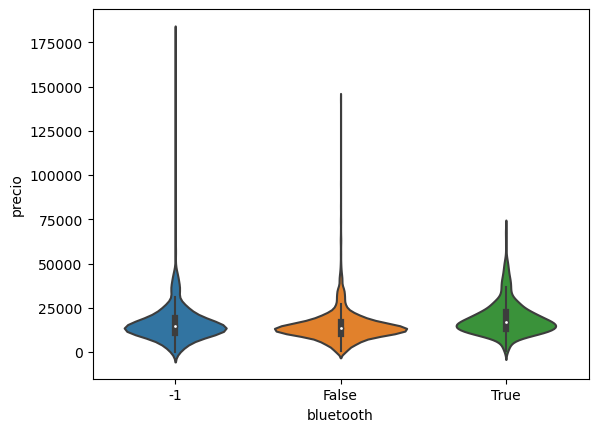

In [62]:
for i in (["bluetooth", "alerta_lim_velocidad", "aire_acondicionado"]):
    plot = sns.violinplot(data=df_bmw, x=i, y="precio", kind="strip")
    plot.set_xticklabels(rotation=45)

/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


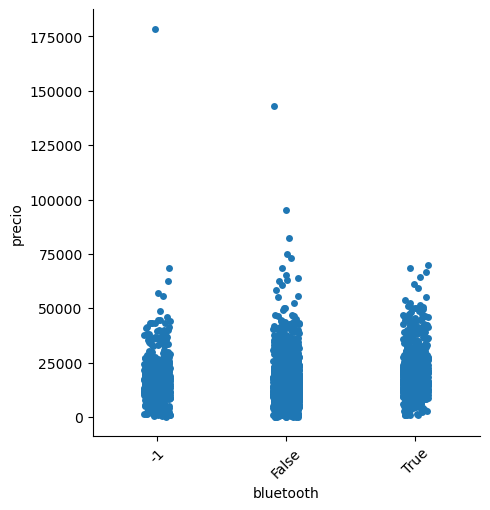

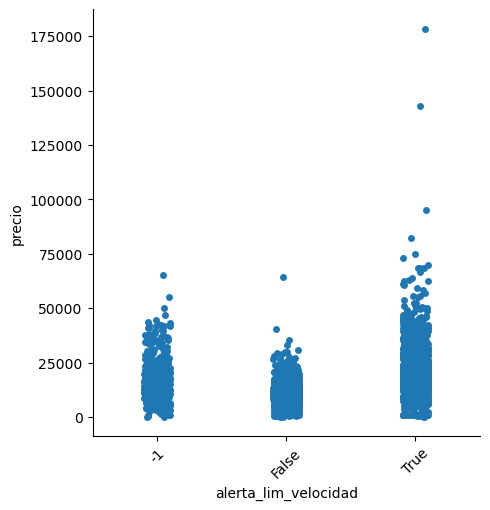

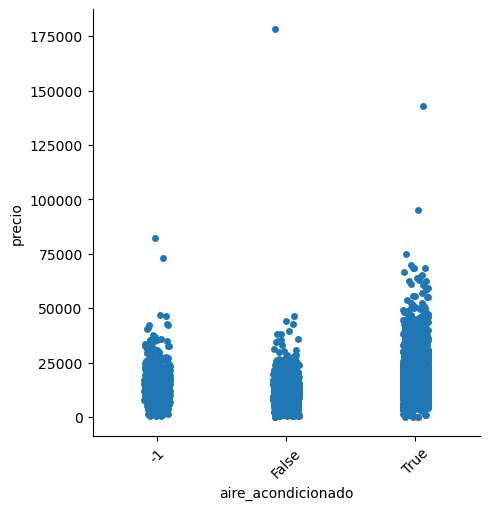

In [91]:
for i in (["bluetooth", "alerta_lim_velocidad", "aire_acondicionado"]):
    plot = sns.catplot(data=df_bmw, x=i, y="precio", kind="strip")
    plot.set_xticklabels(rotation=45)       

In [63]:
#6. Variable "FECHA_REGISTRO"
df_bmw["fecha_registro"].str[:4].value_counts()


In [94]:
#3. Variable "Fecha_Registro"

#Análisis

df_bmw_teste = df_bmw.copy()
df_bmw_teste["fecha_registro"] = df_bmw["fecha_registro"].str[:4]
df_bmw_teste["fecha_venta"] = df_bmw_teste["fecha_venta"].str[:4]
df_bmw_teste["fecha_registro"].value_counts()


fecha_registro
2013    754
2014    632
2012    432
2015    162
2011    116
2010     51
2016     46
2008     42
2009     39
2007     29
2006     29
2005     28
2004     10
2001      8
2003      8
2017      5
2002      4
1997      4
2000      3
1999      3
1995      1
1990      1
1994      1
Name: count, dtype: int64

/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


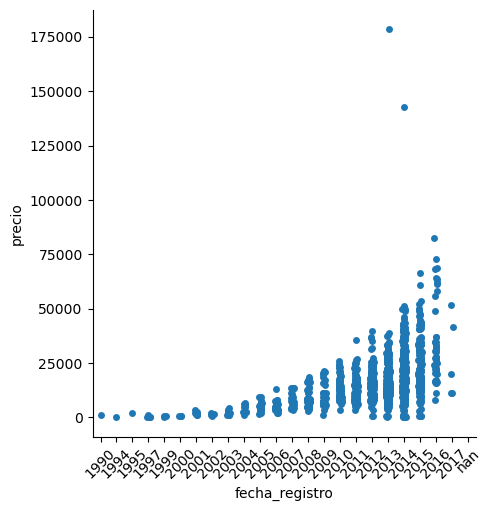

In [102]:
plot = sns.catplot(data=df_bmw_teste.sort_values(by="fecha_registro", ascending=True), x="fecha_registro", y="precio", kind="strip")
plot.set_xticklabels(rotation=45)       

<Axes: >

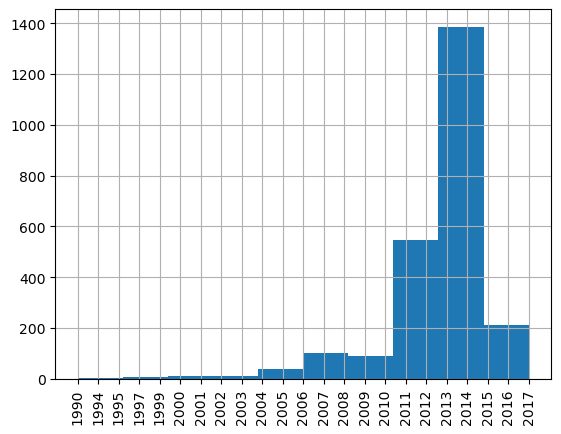

In [93]:
df_bmw_teste["fecha_registro"].sort_values(ascending=True).hist(xrot=90)

In [103]:
#La variabble indica la antiguedad del coche, que podría impactar en precio (reversamente).
#Todavía, aporta 50% de nulos que no pueden ser estimados por medio de otras variables. Los valores se concentran en 3 categorias basicamente (2012, 2013 y 2014).
#Se concluye, así, por la eliminación de la variable.

df_bmw.drop(columns="fecha_registro", inplace=True)


In [104]:
listarNulos(df_bmw)

,Nulos,percentaje


<h2> Análisis Univariable</h2>

<h3> Conversion de tipos de datos</h3>

In [105]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4817 entries, 0 to 4842
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   marca                 4817 non-null   object 
 1   modelo                4817 non-null   object 
 2   km                    4817 non-null   float64
 3   potencia              4817 non-null   float64
 4   tipo_gasolina         4817 non-null   object 
 5   color                 4817 non-null   object 
 6   tipo_coche            4817 non-null   object 
 7   volante_regulable     4817 non-null   object 
 8   aire_acondicionado    4817 non-null   object 
 9   camara_trasera        4817 non-null   object 
 10  elevalunas_electrico  4817 non-null   object 
 11  bluetooth             4817 non-null   object 
 12  gps                   4817 non-null   bool   
 13  alerta_lim_velocidad  4817 non-null   object 
 14  precio                4817 non-null   float64
 15  fecha_venta           4817

In [114]:
#Variables categoricas - dicotómicas/booleanas :
lista_bool = ['volante_regulable', 'aire_acondicionado',
       'camara_trasera', 'elevalunas_electrico', 'bluetooth', 'gps',
       'alerta_lim_velocidad']

#Variables numericas
lista_num = df_bmw.select_dtypes("number")

#Variables categoricas
lista_cat = ['marca', 'modelo', 'tipo_gasolina', 'color','tipo_coche']

In [118]:
#Conversión de las variables categóricas/dicotómicas a enteros
for i in lista_bool:
       col=i+"_BOOL"
       df_bmw[col] = df_bmw[i].astype("int8")
       del(df_bmw[i])

#Verificación
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4817 entries, 0 to 4842
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   marca                      4817 non-null   object 
 1   modelo                     4817 non-null   object 
 2   km                         4817 non-null   float64
 3   potencia                   4817 non-null   float64
 4   tipo_gasolina              4817 non-null   object 
 5   color                      4817 non-null   object 
 6   tipo_coche                 4817 non-null   object 
 7   precio                     4817 non-null   float64
 8   fecha_venta                4817 non-null   object 
 9   volante_regulable_BOOL     4817 non-null   int8   
 10  aire_acondicionado_BOOL    4817 non-null   int8   
 11  camara_trasera_BOOL        4817 non-null   int8   
 12  elevalunas_electrico_BOOL  4817 non-null   int8   
 13  bluetooth_BOOL             4817 non-null   int8   
 1

In [121]:
for i in df_bmw:
    print('\n',i,df_bmw[i].unique(),'\n')


 marca ['BMW'] 


 modelo ['118' 'M4' '320' '420' '425' '335' '325' 'Z4' '120' '220' '650' '135'
 '218' '318' '430' 'M3' '330' '225' 'M235' '316' '435' '640'
 '640 Gran Coupé' '435 Gran Coupé' 'i8' '630' '430 Gran Coupé' '635' '520'
 '525' '530' '535' '320 Gran Turismo' '518' '116' '328' '523' 'X3' 'M550'
 '528' '325 Gran Turismo' '125' '318 Gran Turismo' '420 Gran Coupé' 'i3'
 '114' '520 Gran Turismo' '530 Gran Turismo' 'M135' '418 Gran Coupé'
 '330 Gran Turismo' '335 Gran Turismo' '730' '123' '535 Gran Turismo'
 '740' '750' 'ActiveHybrid 5' '735' 'M5' 'X5' 'X1' 'X4' 'X6' 'X6 M' 'X5 M'
 'X5 M50' '218 Active Tourer' '218 Gran Tourer' '216' '220 Active Tourer'
 '216 Gran Tourer' '216 Active Tourer' ' Active Tourer'
 '225 Active Tourer' '214 Gran Tourer'] 


 km [140411.  13929. 183297. ...  19633.  27920. 195840.] 


 potencia [100. 317. 120. 135. 160. 225. 145. 105. 125. 130. 270. 110. 140. 180.
  85. 190. 236. 240. 250. 230. 309. 170. 142. 155. 210. 122. 200.  90.
 150. 141. 173. 137

In [ ]:
#Variable MARCA
#Solo tiene un tipo de valor "Bmw" (baja varianza), por lo cual se decide borrarla, por no aportar valor al contexto:

del(df_bmw["marca"])

In [127]:
#Variable FECHA_VENTA
#Creación de nueva variable con "año - mes" para análisis de distribución:
df_bmw["fecha_venta_mesano"] = df_bmw["fecha_venta"].str[:7]
df_bmw["fecha_venta_mesano"]

0       2018-01
1       2018-02
2       2018-02
3       2018-02
4       2018-04
         ...   
4838    2018-08
4839    2018-08
4840    2018-09
4841    2018-09
4842    2018-09
Name: fecha_venta_mesano, Length: 4817, dtype: object

/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


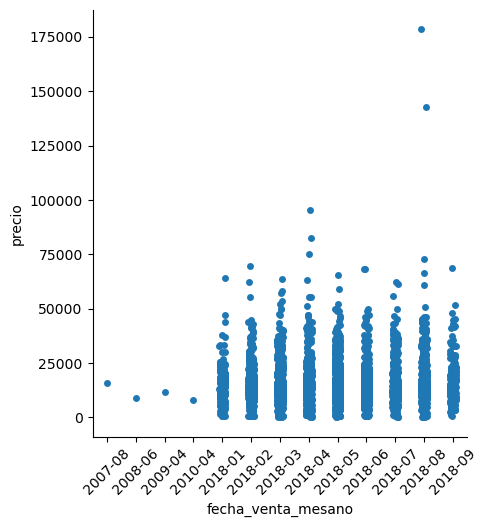

In [129]:
plot = sns.catplot(data=df_bmw.sort_values(by="fecha_venta_mesano", ascending=True), x="fecha_venta_mesano", y="precio", kind="strip")
plot.set_xticklabels(rotation=45)      

In [133]:
#Se verifique que la variable practicamente contiene datos referente al año de 2018 y de forma parcial em relación a sus meses. 
#Considerando apenas el contenido del año, representa baja varianza.
#En respeto al precio, la distribución es muy equilibrada, lo que lleva a creer que no impacta de modo relevante en la variable precio. 
#Por lo tanto, se decide borrarla.

df_bmw.drop(columns= ["fecha_venta","fecha_venta_mesano"],inplace=True)


In [135]:
#Verificación
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4817 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   modelo                     4817 non-null   object 
 1   km                         4817 non-null   float64
 2   potencia                   4817 non-null   float64
 3   tipo_gasolina              4817 non-null   object 
 4   color                      4817 non-null   object 
 5   tipo_coche                 4817 non-null   object 
 6   precio                     4817 non-null   float64
 7   volante_regulable_BOOL     4817 non-null   int8   
 8   aire_acondicionado_BOOL    4817 non-null   int8   
 9   camara_trasera_BOOL        4817 non-null   int8   
 10  elevalunas_electrico_BOOL  4817 non-null   int8   
 11  bluetooth_BOOL             4817 non-null   int8   
 12  gps_BOOL                   4817 non-null   int8   
 13  alerta_lim_velocidad_BOOL  4817 non-null   int8   
dt

In [138]:
#Variable TIPO_GASOLINA
#Se verifica que contiene valores "diesel" pero también "Diesel", que, efetivamente, és lo mismo.
#Se decise, así, agruparlas en "diesel", de modo a manterner el mismo estándar de las demás.

df_bmw["tipo_gasolina"] = np.where(df_bmw["tipo_gasolina"]=="Diesel", "diesel", df_bmw["tipo_gasolina"])

#verificación
df_bmw["tipo_gasolina"].unique()

array(['diesel', 'petrol', 'hybrid_petrol', 'electro'], dtype=object)

/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


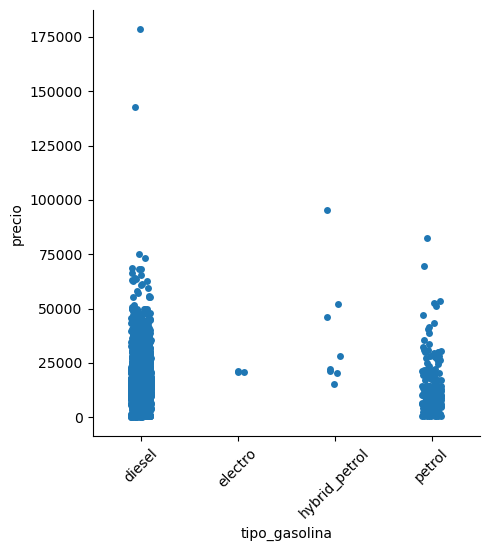

In [144]:
plot = sns.catplot(data=df_bmw.sort_values(by="tipo_gasolina", ascending=True), x="tipo_gasolina", y="precio", kind="strip")
plot.set_xticklabels(rotation=45)      

<Axes: xlabel='potencia'>

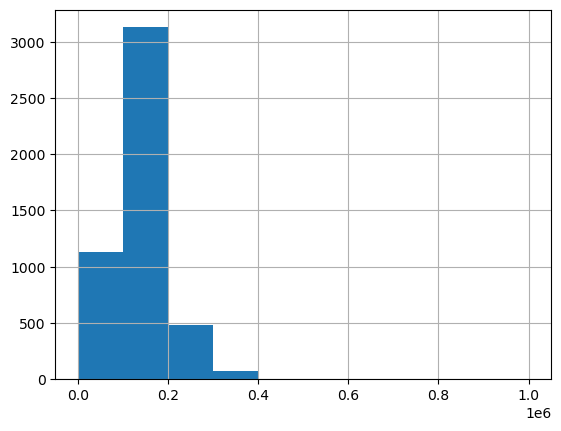

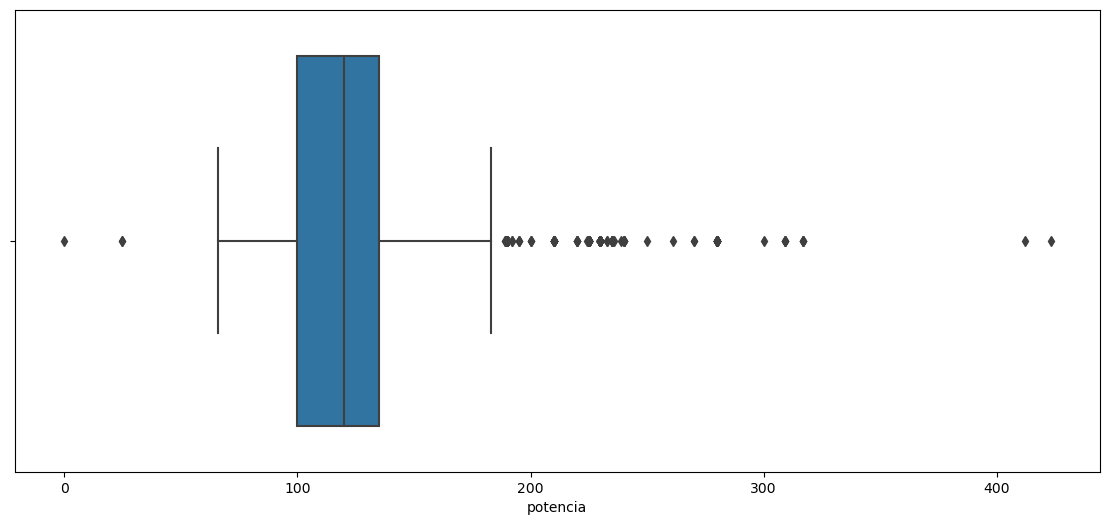

In [152]:
#Variable KM

df_bmw["km"].hist()
#sns.histplot(data=df_bmw, x="km", y="precio", palette="Set1")
plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.boxplot(data=df_bmw, x="potencia")

In [ ]:
i=1 #posição, depende da coluna "3" e da linha "2"
#corr_mat = df_bmw_sin_nulos.select_dtypes("number").corr().stack().reset_index(name="correlation")
#corr_mat2 = df_bmw_sin_nulos.select_dtypes("number").corr().stack().reset_index(name="correlation")
corr_mat = df_bmw_sin_nulos.select_dtypes("number").corr()
corr_mat2 = df_bmw_subs_nulos.select_dtypes("number").corr()
corr_mat3 = df_bmw_subzero.select_dtypes("number").corr()

corr_mat4 = df_bmw_sin_nulos.drop(columns="asientos_traseros_plegables").select_dtypes("number").corr()
corr_mat5 = df_bmw_subs_nulos.drop(columns="asientos_traseros_plegables").select_dtypes("number").corr()
corr_mat6 = df_bmw_subzero.drop(columns="asientos_traseros_plegables").select_dtypes("number").corr()
  
# Crear una figura y ejes para los subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))

# Crear los subplots utilizando Seaborn
colormap = plt.cm.RdBu

sns.heatmap (corr_mat, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[0,0])
colormap = plt.cm.RdBu

sns.heatmap (corr_mat2, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[0,1])

colormap = plt.cm.RdBu

sns.heatmap (corr_mat3, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[0,2])

colormap = plt.cm.RdBu

sns.heatmap (corr_mat4, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[1,0])
colormap = plt.cm.RdBu

sns.heatmap (corr_mat5, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[1,1])
colormap = plt.cm.RdBu

sns.heatmap (corr_mat6, linewidths = 0.3, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[1,2])


# Añadir títulos y etiquetas a los subplots
#axes[0].set_title('SIN NULOS')
#axes[1].set_title('NULOS = -1')
#axes[2].set_title('NULOS = 0')




# Ajustar el espaciado entre los subplots
plt.tight_layout()
# Mostrar los subplots
plt.show()


In [ ]:
i=1 #posição, depende da coluna "3" e da linha "2"
#corr_mat = df_bmw_sin_nulos.select_dtypes("number").corr().stack().reset_index(name="correlation")
#corr_mat2 = df_bmw_sin_nulos.select_dtypes("number").corr().stack().reset_index(name="correlation")
corr_mat = df_bmw_sin_nulos.select_dtypes("number").corr()
corr_mat2 = df_bmw_subs_nulos.select_dtypes("number").corr()
corr_mat3 = df_bmw_subzero.select_dtypes("number").corr()
  
# Crear una figura y ejes para los subplots
fig, axes = plt.subplots(ncols=3, figsize=(32, 10))

# Crear los subplots utilizando Seaborn
colormap = plt.cm.RdBu

sns.heatmap (corr_mat, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[0])
colormap = plt.cm.RdBu

sns.heatmap (corr_mat2, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[1])

colormap = plt.cm.RdBu

sns.heatmap (corr_mat3, linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, ax=axes[2])

# Añadir títulos y etiquetas a los subplots
axes[0].set_title('Scatterplot')
axes[1].set_title('Boxplot')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
# Mostrar los subplots
plt.show()


In [ ]:
sns.pairplot(df_bmw_sin_nulos.select_dtypes("number"), 
             
             palette="tab10", 
             corner=True)
plt.show()

In [ ]:
df_bmw_sin_atPlegables = df_bmw.drop(columns=["asientos_traseros_plegables"])
df_bmw_sin_nulos2 = df_bmw_sin_atPlegables.dropna()


lista = df_bmw_sin_atPlegables.isin([True,False]).any()
lista
colunas_boolean =list(lista[lista].index)

df_bmw_sin_nulos2[colunas_boolean] = df_bmw_sin_nulos2[colunas_boolean].astype("int8")
df_bmw_sin_nulos2.info()


In [ ]:
#Colunas booleanas:


#df_bmw.dropna().select_dtypes(include='float').corr()
#df_bmw_sin_nulos = df_bmw.dropna()
#lista = ["volante_regulable","aire_acondicionado"]
#df_bmw_sin_nulos[lista] = df_bmw_sin_nulos[lista].astype("int8")
#df_bmw_sin_nulos.info()


In [ ]:
#df_bmw[df_bmw[["modelo"]].isnull()]
#pandas.DataFrame.select_dtypes()", que retorna un subconjunto de datos basado en sus tipos. Así, es posible coger solo las columnas numéricas con "df.select_dtypes(include='number').columns" o "df.select_dtypes(include=['int', 'float']).columns" / booleanas con "df.select_dtypes(include='bool').columns" y caracteres con "df.select_dtypes(include='category'), de modo a, creo, utilizarlas en lugar de la función  "def obtener_lista_variables(dataset):" en los ejemplos de clase.df_bmw[["modelo"]].isnull()
msno.matrix(df_bmw)

In [ ]:


df_bmw[df_bmw["modelo"].isnull()]


In [ ]:
df_bmw_columnas_sin_nulos.shape

In [ ]:
df_bmw.isnull().any(axis=1)

In [ ]:
col_nulos = df_bmw.isnull().sum().sort_values(ascending=False)
col_nulos

In [ ]:
sns.heatmap(df_bmw[col_nulos.index].isnull(), cbar=False)

In [ ]:
#Data Binning
bins = np.linspace(min(df_bmw["precio"]), max(df_bmw["precio"]), 4)
group_names = ["Low","Medium","High"]

x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x.columns = ["bin"]
#x.hist()
#x.value_counts()
x["precio"] = df_bmw["precio"]
x

In [ ]:
sns.catplot(x,x=x["bin"],y=x["precio"])

In [ ]:
n = np.arange(11)
n

In [ ]:
from itertools import islice
#Data Binning
nbins=3
step_bins=df_bmw["precio"].shape[0]//nbins
#zeta = list(islice(df_bmw["precio"].sort_values(ascending=True), 1000))
#zeta = np.array_split(df_bmw["precio"].sort_values(ascending=True), step_bins)
#zeta
#x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x= pd.DataFrame(pd.cut(df_bmw["precio"].sort_values(ascending=True),2))
x

In [ ]:
#df_bmw[df_bmw["tipo_coche","tipo_gasolina"].isnull()].groupby(["modelo","tipo_coche","tipo_gasolina"],dropna=False)["tipo_coche"].value_counts()

In [ ]:
sns.pairplot(df_bmw, 
             hue='modelo', 
             palette="tab10", 
             corner=True)
plt.show()

In [ ]:
df_bmw.describe().loc[['min', 'max']]


In [ ]:
list(df_bmw.columns)


In [ ]:
df_bmw.describe().loc[['mean', 'std']].T

Databinning

In [ ]:
#Categorias por quantidade de elementos
z=pd.DataFrame(df_bmw["precio"].sort_values(ascending=True))
z["binning"] = pd.qcut(df_bmw["precio"].sort_values(ascending=True), 3,labels=["baixo", "medio", "alto"])
z["binning"].hist()
#sns.catplot(z,x=z["binning"],y=z["precio"])






In [ ]:
#Por faixa de elementos
bins = np.linspace(min(df_bmw["precio"]), max(df_bmw["precio"]), 4)
group_names = ["Low","Medium","High"]
x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x.columns = ["bin"]
x["precio"] = df_bmw["precio"]
x

Gráficos

In [ ]:
#SNS Pairplot
sns.pairplot(df, 
             hue='label', 
             palette="tab10", 
             corner=True)

plt.show()

In [ ]:
#multiples gráficos - interessante para automações

i=1 #posição, depende da coluna "3" e da linha "2"
plt.figure(figsize=(15,6))
plt.subplot(2,3,i)
sns.histplot(data=df_bmw, x="precio", kde=True)
plt.subplot(2,3,i+3)
sns.histplot(data=df_bmw, x="modelo")
plt.tight_layout()


Otros

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# example data
x = np.arange(0.1, 4, 0.1)
y1 = np.exp(-1.0 * x)
y2 = np.exp(-0.5 * x)

# example variable error bar values
y1err = 0.1 + 0.1 * np.sqrt(x)
y2err = 0.1 + 0.1 * np.sqrt(x/2)


fig, (ax0, ax1, ax2,bx1) = plt.subplots(nrows=1, ncols=4, sharex=True,
                                    figsize=(12, 6))

ax0.set_title('all errorbars')
ax0.errorbar(x, y1, yerr=y1err)
ax0.errorbar(x, y2, yerr=y2err)

ax1.set_title('only every 6th errorbar')
ax1.errorbar(x, y1, yerr=y1err, errorevery=6)
ax1.errorbar(x, y2, yerr=y2err, errorevery=6)

ax2.set_title('second series shifted by 3')
ax2.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
ax2.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

bx1.set_title('IUHahIS series shifted by 3')
bx1.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
bx1.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

fig.suptitle('Errorbar subsampling')
plt.show()

In [ ]:
#recuento de elementos enteros o convertibles para ennteros
np.bincount(df_bmw["asientos_traseros_plegables"].dropna())


In [ ]:
df_bmw["precio"].quantile(0.25)

In [ ]:
sns.boxplot(df_bmw, x="precio")

In [ ]:
# Identificando valores nulos
df_bmw.isnull().any()

# Criando dicionários para adicioinar os valores
dict_outliers_zscore = {}
dict_outliers_iqr = {}
dict_outliers_percentile = {}

# Definindo uma função para coleta de outliers por meio do método Z-score com maior robustez
def z_r_score_outlier(data):
    outliers = []
    med = np.median(data)
    ma = stats.median_abs_deviation(data)
    for i in data: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            outliers.append(i)      
    return outliers

# Definindo uma função para coleta de outliers por meio do método IQR
def iqr_outliers(data):
    outliers = []
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 2.5 * iqr
    Upper_tail = q3 + 2.5 * iqr
    for i in data:
        if i > Upper_tail or i < Lower_tail:
            outliers.append(i)
    return outliers

# Definindo uma função para coleta de outliers por meio da análise do percentil
def winsorization_outliers(data):
    outliers = []
    q1 = np.percentile(data, 1)
    q3 = np.percentile(data, 99)
    for i in data:
        if i > q3 or i < q1:
            outliers.append(i)
    return outliers
    
# Coletando os outliers
for i in df_bmw.columns:
    if df_bmw[i].dtype == "float64":
        df_order=df_bmw[i].sort_values(ascending=True)
        outliers_zscore = z_r_score_outlier(df_order)
        if len(outliers_zscore) > 0:
            dict_outliers_zscore[i] = outliers_zscore
        outliers_iqr = iqr_outliers(df_order)
        if len(outliers_iqr) > 0:
            dict_outliers_iqr[i] = outliers_iqr
        outliers_percentile = winsorization_outliers(df_order)
        if len(outliers_percentile) > 0:
            dict_outliers_percentile[i] = outliers_percentile
            
# Observando os outliers
print("WINSOR")
for i in dict_outliers_percentile.items():
    print(i)

# Observando os outliers
print("IQR")
for i in dict_outliers_iqr.items():
    print(i)


# Observando os outliers
print("ZEND")
for i in dict_outliers_zscore.items():
    print(i)


#df_numerical = df.select_dtypes(include = ['int','float'])


In [ ]:
x=1
plt.figure(figsize=(15,6))
for i in df_bmw.columns:
    if df_bmw[i].dtype == "float64":
        plt.subplot(2,3,x)
        sns.histplot(data=df_bmw, x=i, kde=True)
        plt.subplot(2,3,x+3)
        sns.boxplot(data=df_bmw, x=i)
        plt.tight_layout()
        x+=1

In [ ]:
df_bmw.info()